# Metaheuristic Algorithms
Following sections try some techniques from stochasitic optimization, also known as *metaheuristics*.

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

<AxesSubplot:xlabel='#resources', ylabel='min. makespan'>

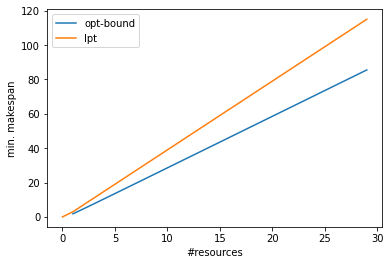

In [2]:
num_instances = 30
num_trials = 5
max_iters = 1000

problem_instances = list(generate_subopt_instances(num_instances))

def eval_lpt(R, p):
    _, m, r, = lpt(R, p)
    return m / r, m

lpt_df = pd.DataFrame((eval_lpt(R, p) for R, p in problem_instances), columns=['opt-bound', 'lpt'])
lpt_df.plot.line(xlabel='#resources', ylabel='min. makespan')

## Simulated Annealing

### Sanity check
Note that the optimal value for this instance is 9.

In [3]:
R = 3
p = [5, 5, 4, 4, 3, 3, 3]

schedule, makespan = anneal(R, p)
makespan

9.0

In [4]:
gantt_df = gantt(R, p, schedule)
gantt_df

,task,start,finish,resource
0,1,0.0,5.0,0
1,2,5.0,9.0,0
2,0,0.0,5.0,1
3,3,5.0,9.0,1
4,4,0.0,3.0,2
5,5,3.0,6.0,2
6,6,6.0,9.0,2


### SA evaluation
Comparison of the solution quality between SA and LPT on problem instances for which LPT is known to be sub-optimal.

Because SA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, SA is evaluated for each of the following *tweak* operators:
1. `vec_tweak` - for each task re-assign it to random resource with probabilyty `1/n` (`n` is no. tasks)
1. `point_tweak` - pick a task at random and assign it to random resource
1. `swap_tweak` - pick two tasks at random and swap the resources they are assigned to
each operator is then used with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P).

In [5]:
tweak_operators = [vec_tweak, point_tweak, swap_tweak]

def makespan(R, p, tweak, penalize):
    _, m = anneal(R, p, tweak, max_iters, penalize=penalize)
    return m

def mean_makespan(R, p, tweak, penalize):
    return sum(makespan(R, p, tweak, penalize) for _ in range(num_trials)) / num_trials

def evaluate_tweak(tweak, penalize):
    return pd.Series([mean_makespan(R, p, tweak, penalize) for R, p in problem_instances])

In [6]:
tweak_df = pd.DataFrame({tweak.__name__: evaluate_tweak(tweak, penalize=False) for tweak in tweak_operators})
tweak_df = pd.concat([lpt_df, tweak_df], axis=1)
tweak_df.tail()

,opt-bound,lpt,vec_tweak,point_tweak,swap_tweak
25,73.514851,99.0,133.6,133.2,142.6
26,76.514286,103.0,135.6,140.0,164.6
27,79.513761,107.0,142.2,141.8,164.0
28,82.513274,111.0,148.6,146.4,182.4
29,85.512821,115.0,156.4,154.8,169.8


<AxesSubplot:xlabel='#resources', ylabel='min. makespan (mean for SA)'>

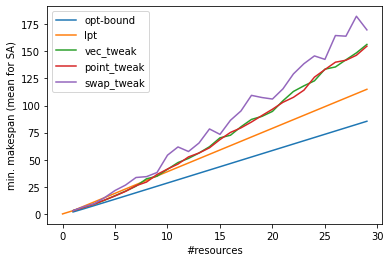

In [7]:
tweak_df.plot.line(xlabel='#resources', ylabel='min. makespan (mean for SA)')

Now let's try one of the better tweak operators with a penalty to solution quality. This penalty is equal to `#unused resources * M` where `M` is some big-enough constant (e.g. `M = sum(p)`).

<AxesSubplot:xlabel='#resources', ylabel='mean min. makespan (vec_tweak)'>

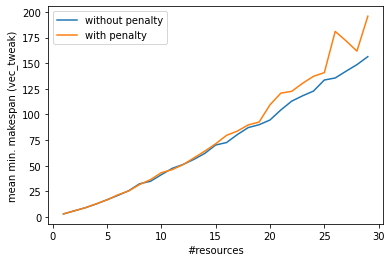

In [8]:
tweak_penalty_df = pd.DataFrame(
    {
        'without penalty': tweak_df['vec_tweak'],
        'with penalty': evaluate_tweak(tweak=vec_tweak, penalize=True),
    }
)
tweak_penalty_df.plot.line(xlabel='#resources', ylabel='mean min. makespan (vec_tweak)')

## Evolutionary algorithms

### Sanity check
Note that the optimal value for this instance is 9.

In [9]:
R = 3
p = [5, 5, 4, 4, 3, 3, 3]

schedule, makespan = evolve(R, p, two_point_crossover, mutate=mutation(vec_tweak, R))
makespan

9.0

In [10]:
gantt_df = gantt(R, p, schedule)
gantt_df

,task,start,finish,resource
0,0,0.0,5.0,0
1,3,5.0,9.0,0
2,4,0.0,3.0,1
3,5,3.0,6.0,1
4,6,6.0,9.0,1
5,1,0.0,5.0,2
6,2,5.0,9.0,2


### EA evaluation
Comparison of the solution quality between EA and LPT on problem instances for which LPT is known to be sub-optimal.

Because EA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, EA uses `vec_tweak` as the mutation operator, `two_point_crossover` as the mating operator and we run it for 
* varying population sizes: 10, 100
* with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P)

In [11]:
crossover = two_point_crossover
tweak=vec_tweak
pop_sizes = (10, 100)

def makespan(R, p, pop_size, penalize):
    _, m = evolve(
        R=R,
        p=p,
        mate=crossover,
        mutate=mutation(tweak, R),
        pop_size=pop_size,
        max_iters=max_iters,
        penalize=penalize,
    )
    return m

def mean_makespan(R, p, pop_size, penalize):
    return sum(makespan(R, p, pop_size, penalize) for _ in range(num_trials)) / num_trials

def evaluate_evolve(pop_size, penalize):
    return pd.Series([mean_makespan(R, p, pop_size, penalize) for R, p in problem_instances])

In [12]:
evolve_df = pd.DataFrame({f'evolve-{pop_size}': evaluate_evolve(pop_size, penalize=False) for pop_size in pop_sizes})
evolve_df = pd.concat([lpt_df, evolve_df], axis=1)
evolve_df.tail()

,opt-bound,lpt,evolve-10,evolve-100
25,73.514851,99.0,91.2,90.8
26,76.514286,103.0,104.0,95.0
27,79.513761,107.0,98.8,100.6
28,82.513274,111.0,105.8,105.0
29,85.512821,115.0,111.6,106.6


<AxesSubplot:xlabel='#resources', ylabel='min. makespan (mean for EA)'>

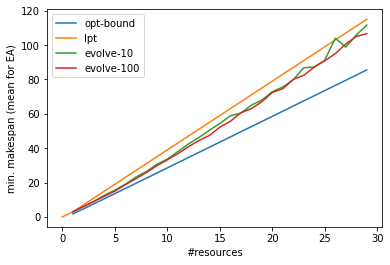

In [13]:
evolve_df.plot.line(xlabel='#resources', ylabel='min. makespan (mean for EA)')

Similarly to SA, let's check if using a penalty for unused resources helps to find better schedules.

<AxesSubplot:xlabel='#resources', ylabel='min. makespan (mean for EA; pop=100)'>

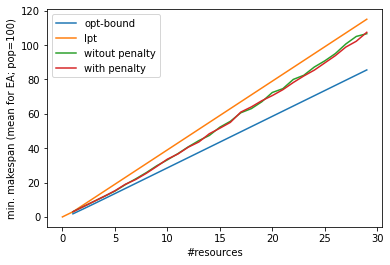

In [17]:
penalty_df = pd.DataFrame(
    {
        'witout penalty': evolve_df['evolve-100'],
        'with penalty': evaluate_evolve(pop_size=100, penalize=True),
    }
)
penalty_df = pd.concat([lpt_df, penalty_df], axis=1)
penalty_df.plot.line(xlabel='#resources', ylabel='min. makespan (mean for EA; pop=100)')